# Corporación Favorita Time Series - Exploratory Data Analysis

***
<br>




<img src="../../reports/img/Corporación_Favorita_Logo.png" width=400 height=300 />

<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>In this second notebook we will perform an Exploratory Data Analysis. This section comes after the Data Wrangling step. This step involves creating plots and charts to understand the relationship between data and the features of that data.<p>
</div>

<br>

### Table of Contents

- [Importing Libraries](#importing)
- [Importing Data](#data)
- [Checking content of dataframes](#checking)
- [Exploratory Data Analysis](#eda)
    - [Plotting our dataframes](#plotting)
        - [Oil Prices](#oil)
        - [Transactions](#transactions)
        - [Holidays](#holidays)
        - [Products (train dataset)](#products)
    - [Clustermap:](#clustermap) Are sales of families of products correlated between them?
    - [Volcano Plot:](#volcano) What family of products are most influenced by promotions?
    - [Top 3 Families:](#top3) What family of products are sold most each month?

<a id='importing'></a>

## Importing libraries

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import re
import string
import tqdm
import os.path
from datetime import datetime

#Settings
sns.set()
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

<a id='data'></a>

## Importing Data

***

This dataset comes from a Kaggle competition called [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data)

There are 6 relevant datasets:
 - `train`
 - `test`
 - `items`
 - `transactions`
 - `holidays`
 - `oil`

In [2]:
train = pd.read_csv('../../data/train_clean.csv', parse_dates=['date'], date_parser=dateparse,  dtype={'id': int, 'store_nbr': int, 'item_nbr': int, 'unit_sales': float, 'onpromotion':object})
test = pd.read_csv('../../data/test.csv', parse_dates=['date'], date_parser=dateparse)
items = pd.read_csv('../../data/items.csv')
transactions = pd.read_csv('../../data/transactions.csv', parse_dates=['date'], date_parser=dateparse)
holidays = pd.read_csv('../../data/holidays.csv', parse_dates=['date'], date_parser=dateparse)
oil = pd.read_csv('../../data/oil.csv', parse_dates=['date'], date_parser=dateparse)

In [3]:
train = train.drop('Unnamed: 0', axis=1).set_index('date')
test = test.drop('Unnamed: 0', axis=1).set_index('date')
items = items.drop('Unnamed: 0', axis=1)
transactions = transactions.drop('Unnamed: 0', axis=1).set_index('date').asfreq(freq='1D') 
holidays = holidays.drop('Unnamed: 0', axis=1).set_index('date') 
oil = oil.set_index('date').asfreq(freq='1D')

In [4]:
train.onpromotion.replace(to_replace='False',value=False, inplace=True)

In [5]:
#List of dataframes
dataframes = {'Train':train, 'Test':test, 'Items':items, 'Holidays': holidays, 'Oil':oil, 'Transactions': transactions}

<a id='checking'></a>

<a id='definition'></a>

## Checking the content of our dataframes

***

It will be useful to see what information we have at our disposal

In [6]:
for key, value in dataframes.items():
    print(key)
    print(value.columns)
    print()

Train
Index(['id', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'class',
       'perishable', 'price', 'transactions', 'type', 'dow'],
      dtype='object')

Test
Index(['id', 'store_nbr', 'item_nbr', 'onpromotion'], dtype='object')

Items
Index(['item_nbr', 'family', 'class', 'perishable'], dtype='object')

Holidays
Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

Oil
Index(['price'], dtype='object')

Transactions
Index(['store_nbr', 'transactions'], dtype='object')



In [7]:
train.head()

,id,item_nbr,unit_sales,onpromotion,family,class,perishable,price,transactions,type,dow
date,,,,,,,,,,,
2013-01-02,578,103665,2.0,No Info,BREAD/BAKERY,2712,1,93.14,2111.0,Work Day,2
2013-01-02,579,105574,8.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
2013-01-02,580,105575,15.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
2013-01-02,581,105577,2.0,No Info,GROCERY I,1045,0,93.14,2111.0,Work Day,2
2013-01-02,582,105737,2.0,No Info,GROCERY I,1044,0,93.14,2111.0,Work Day,2


In [8]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103520,GROCERY I,1028,0
3,103665,BREAD/BAKERY,2712,1
4,105574,GROCERY I,1045,0


In [9]:
items.family.unique()

array(['GROCERY I', 'BREAD/BAKERY', 'DELI', 'CLEANING', 'POULTRY',
       'PERSONAL CARE', 'LINGERIE', 'BEVERAGES', 'AUTOMOTIVE', 'DAIRY',
       'EGGS', 'GROCERY II', 'MEATS', 'FROZEN FOODS', 'HOME APPLIANCES',
       'SEAFOOD', 'PREPARED FOODS', 'LIQUOR,WINE,BEER', 'BEAUTY',
       'HARDWARE', 'LAWN AND GARDEN', 'PRODUCE', 'HOME AND KITCHEN II',
       'HOME AND KITCHEN I', 'MAGAZINES', 'HOME CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'CELEBRATION',
       'SCHOOL AND OFFICE SUPPLIES', 'LADIESWEAR', 'BOOKS'], dtype=object)

In [10]:
print('Example items class: ', items['class'].unique()[0:10])
print('Length class: ',len(items['class'].unique()))
print('Example items item_number: ', items['item_nbr'].unique()[0:10])
print('Length item number:', len(items['item_nbr'].unique()))

Example items class:  [1093 1067 1028 2712 1045 1034 1044 1092 1032 1030]
Length class:  313
Example items item_number:  [ 96995  99197 103520 103665 105574 105575 105577 105693 105737 105857]
Length item number: 3567


In [11]:
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-12-05,Holiday,Local,Quito,Fundacion de Quito-1,False
2012-12-06,Holiday,Local,Quito,Fundacion de Quito,False
2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False


In [12]:
transactions.head()

,store_nbr,transactions
date,,
2013-01-02,1.0,2111.0
2013-01-03,1.0,1833.0
2013-01-04,1.0,1863.0
2013-01-05,1.0,1509.0
2013-01-06,1.0,520.0


<a id='eda'></a>

## EDA - First steps

***

In [13]:
#we can specify a predetermined style
print(plt.style.available)

#choose one
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<a id='plotting'></a>

## Plotting our dataframes

<a id='oil'></a>

### Oil Prices

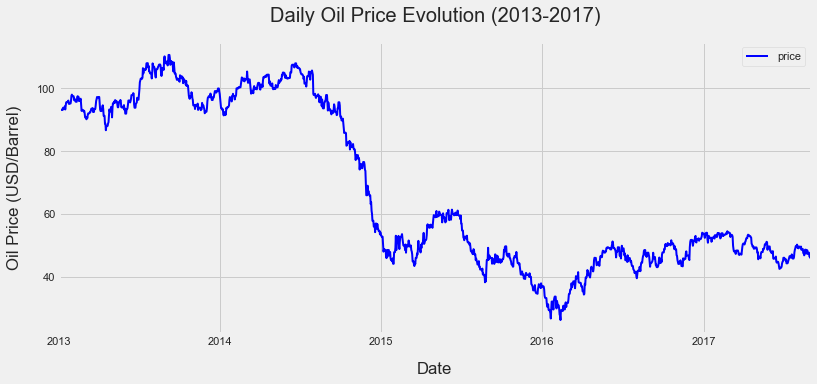

In [14]:
# We plot the daily oil price change
ax = oil.plot(color='blue', figsize=(12,5), linewidth=2)

# Labeling
ax.set_title('Daily Oil Price Evolution (2013-2017)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Oil Price (USD/Barrel)', labelpad=15)

# Show and save plot
plt.savefig('img/Oil/Daily_Oil_Price_Evolution.png', bbox_inches='tight',transparent=True, )
plt.show()

<a id='transactions'></a>

### Transactions

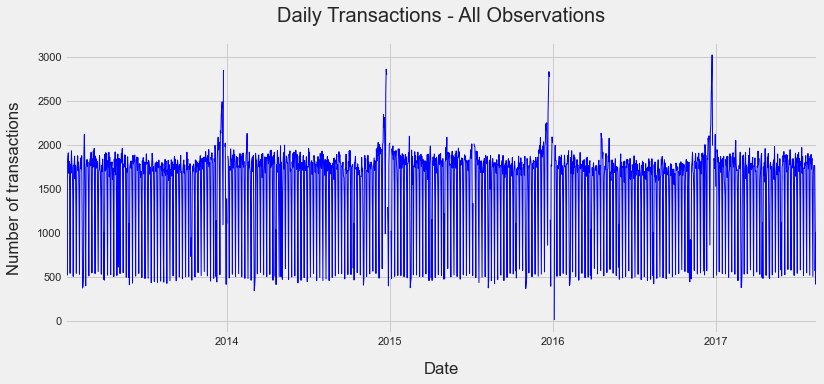

In [15]:
# We plot the daily oil price change
ax = transactions['transactions'].plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - All Observations',pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_All.png', bbox_inches='tight',transparent=True, )
plt.show()

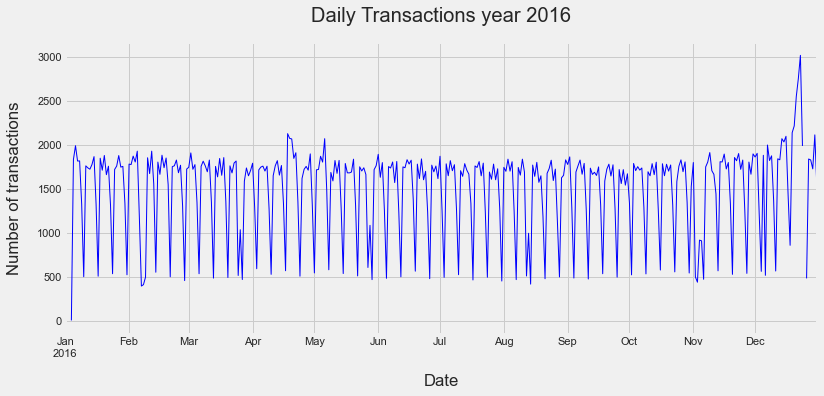

In [16]:
# We plot the daily oil price change
ax = transactions['2016-01-01':'2016-12-31']['transactions'].plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions year 2016', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_2016.png', bbox_inches='tight',transparent=True, )
plt.show()

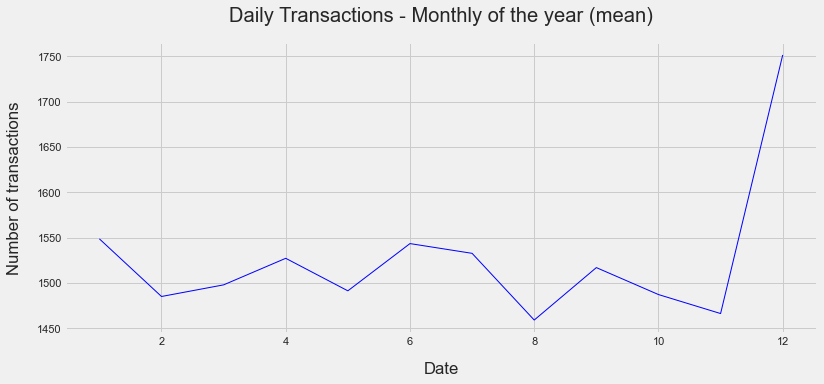

In [17]:
# Get month for each dates in the index
transactions_months = transactions.index.month
transactions_by_months = transactions['transactions'].groupby(transactions_months).mean()

# Plot
ax = transactions_by_months.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Monthly of the year (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Month.png', bbox_inches='tight',transparent=True, )
plt.show()

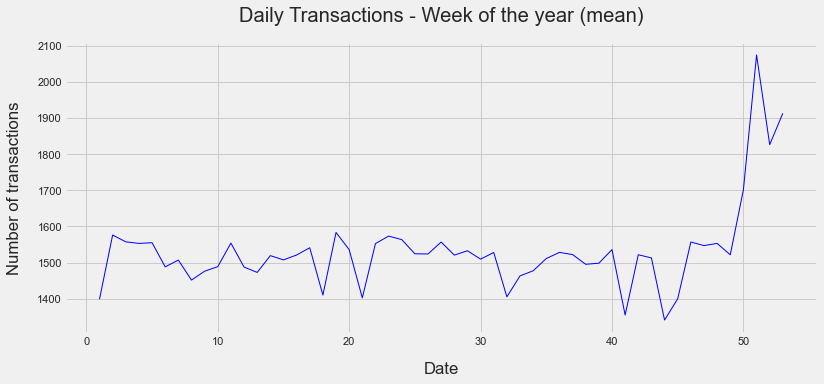

In [18]:
# Get week for each dates in the index
transactions_months = transactions.index.isocalendar().week
transactions_by_months = transactions['transactions'].groupby(transactions_months).mean()

# Plot
ax = transactions_by_months.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Week of the year (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Week.png', bbox_inches='tight',transparent=True, )
plt.show()

<ipython-input-19-dedf75a592ac>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


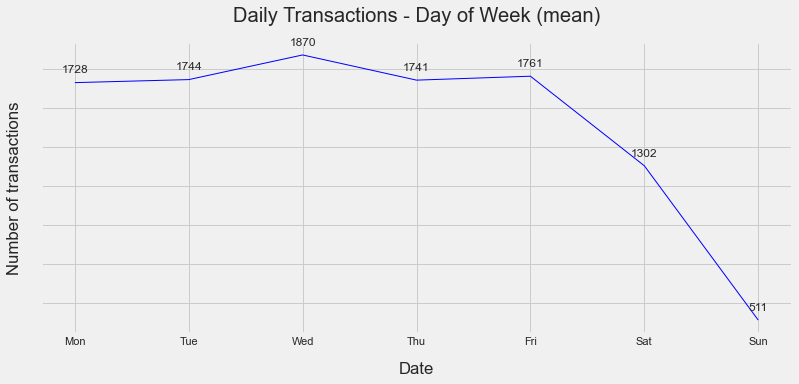

In [19]:
# Get dow for each dates in the index
transactions_dow = transactions.index.dayofweek
transactions_dow = transactions['transactions'].groupby(transactions_dow).mean()

# Plot
ax = transactions_dow.plot(color='blue', figsize=(12,5), linewidth=1)

# Labeling
ax.set_title('Daily Transactions - Day of Week (mean)', pad=20)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Number of transactions', labelpad=15)
ax.set_yticklabels('')
ax.set_xticklabels(labels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for i, v in enumerate(transactions_dow):
    ax.text(i, v+50, "%d" %v, ha="center", fontsize=12)

# Show and save plot
plt.savefig('img/Transactions/Daily_Transactions_Dow.png', bbox_inches='tight',transparent=True, )
plt.show()

In [20]:
dataframes.keys()

dict_keys(['Train', 'Test', 'Items', 'Holidays', 'Oil', 'Transactions'])

<a id='holidays'></a>

### Holidays

In [21]:
holidays['year'] = holidays.index.year

In [22]:
holidays = holidays.iloc[2:]

In [23]:
holidays.index.month

Int64Index([ 1,  1,  1,  2,  2,  4,  5,  5,  5,  5,
            ...
            11, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=171)

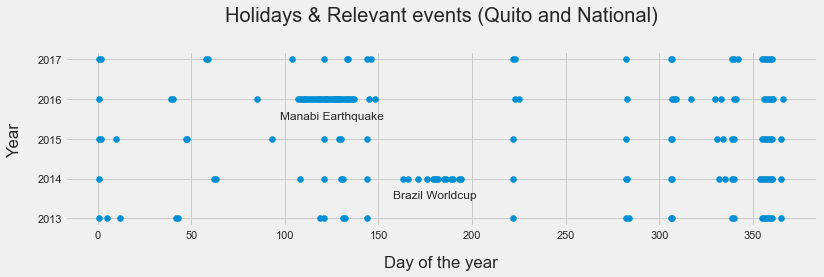

In [24]:
# We plot the daily oil price change
fig, ax = plt.subplots(figsize=(12,3))
colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}
ax.scatter(holidays.index.dayofyear, holidays['year'])

# Labeling
ax.set_title('Holidays & Relevant events (Quito and National)', pad=30)
ax.set_xlabel('Day of the year', labelpad=15)
ax.set_ylabel('Year', labelpad=15)

ax.text(125, 2015.5, 'Manabi Earthquake', ha="center", fontsize=12)
ax.text(180, 2013.5, 'Brazil Worldcup', ha="center", fontsize=12)
    
# Show and save plot
plt.savefig('img/Holidays/Holiday_dates_plotted.png', bbox_inches='tight',transparent=True, )
plt.show()

In [25]:
holidays['2014-06-12':'2014-06-30']

,type,locale,locale_name,description,transferred,year
date,,,,,,
2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,2014
2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,2014
2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,2014
2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,2014
2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014
2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014
2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False,2014


In [26]:
holidays['2016-04-16':'2016-04-20']

,type,locale,locale_name,description,transferred,year
date,,,,,,
2016-04-16,Event,National,Ecuador,Terremoto Manabi,False,2016
2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False,2016
2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False,2016
2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False,2016
2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False,2016


<a id='products'></a>

### Products

There are many products and we cannot analyze them all together but we can create functions that would allow us to drill down on each of them if we need to

In [27]:
choosen_product = 105574
items[items['item_nbr'] == choosen_product]

,item_nbr,family,class,perishable
4,105574,GROCERY I,1045,0


We can also group our products by "family". In the next lines of code we merge the "items" and "train" dataframes

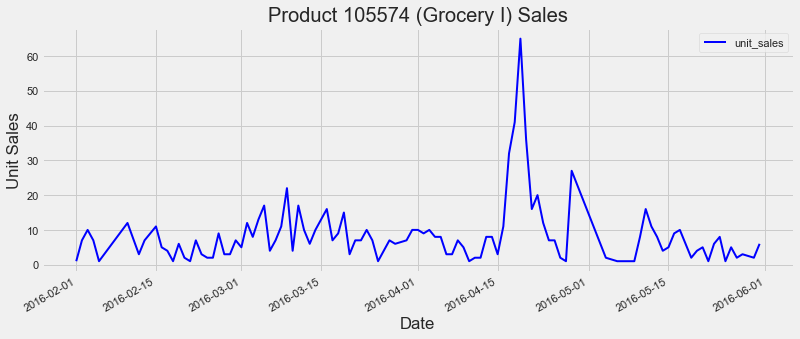

In [28]:
data = train[train['item_nbr'] == choosen_product][['unit_sales']]

ax = data['2016-02-01':'2016-05-31'].plot(color='blue', figsize=(12,5), linewidth=2)

ax.set_title('Product 105574 (Grocery I) Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')

# Show plot
plt.savefig('img/Products/Product_{}_Sales_Example.png'.format(choosen_product), bbox_inches='tight',transparent=True, )
plt.show()

In [29]:
def item_time_series(product,title, start_date='2013-01-01', finish_date='2017-08-15', save_as='time_series_plot', 
                     hline_kwargs=None, vline_kwargs=None, 
                     hregion_kwargs=None, vregion_kwargs=None):
    
    '''Creates a timeseries plot from the items in the store's catalog'''
    
    #data
    data = train[train['item_nbr'] == product][['unit_sales']]

    #plot
    ax = data[start_date:finish_date].plot(color='blue', figsize=(12,5), linewidth=2)

    #design
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    
    #annotations
    # Add a red vertical line
    if hline_kwargs == None:
        pass
    else:
        ax.axvline(**vline_kwargs)

    # Add a green horizontal line
    if vline_kwargs == None:
        pass
    else:
        ax.axhline(**hline_kwargs)
        
    # Add a vertical red shaded region
    if vregion_kwargs == None:
        pass
    else:
        ax.axvspan(**vregion_kwargs)

    # Add a horizontal green shaded region
    if hregion_kwargs == None:
        pass
    else:
        ax.axhspan(**hregion_kwargs)

    # Show plot
    plt.savefig('img/Products/'+save_as+'.png', bbox_inches='tight',transparent=True)
    plt.show()

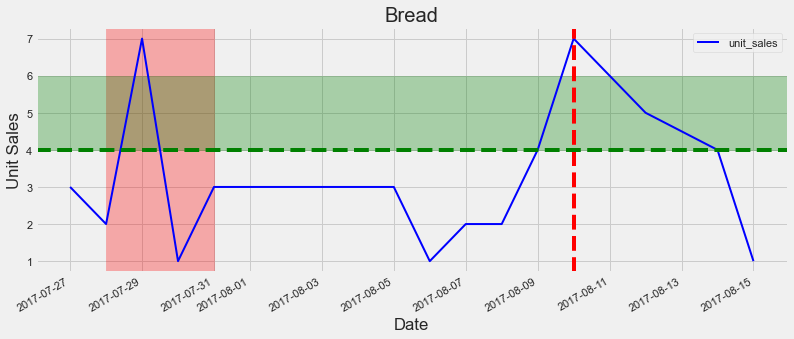

In [30]:
item_time_series(2116416,'Bread', start_date='2017-01-01', finish_date='2017-08-15', save_as='bread_sales_example',
                hline_kwargs={'y':4, 'color':'green', 'linestyle':'--'},
                vline_kwargs={'x':'2017-08-10', 'color':'red', 'linestyle':'--'},
                vregion_kwargs={'xmin':'2017-07-28', 'xmax':'2017-07-31', 'color':'red', 'alpha':0.3},
                hregion_kwargs={'ymin':4, 'ymax':6, 'color':'green', 'alpha':0.3})
                

In [31]:
def item_time_series_ma(product,title, rolling_time_span=7, mean_std=2,
                     start_date='2013-01-01', finish_date='2017-08-15', save_as='time_series_plot'):
    
    '''Creates a timeseries plot from the items in the store's catalog'''
    
    #data
    data = train[train['item_nbr'] == product][['unit_sales']]

    # Compute the rolling mean of the unit sales
    ma = data.rolling(window=rolling_time_span).mean()

    # Compute the rolling standard deviation of the unit sales
    mstd = data.rolling(window=rolling_time_span).std()

    # Add the upper bound column to the ma DataFrame
    ma['upper'] = ma['unit_sales'] + (mean_std * mstd['unit_sales'])

    # Add the lower bound column to the ma DataFrame
    ma['lower'] = ma['unit_sales'] - (mean_std * mstd['unit_sales'])
    ma['lower'] = ma['lower'].apply(lambda x: x*0 if x < 0 else x)                                   

    # Plot the content of the ma DataFrame
    ax = ma[start_date:finish_date].plot(linewidth=0.8, fontsize=10, figsize=(12,5))

    # Specify labels, legend
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    
    # Show plot
    plt.savefig('img/Products/'+save_as+'.png', bbox_inches='tight',transparent=True)
    plt.show()

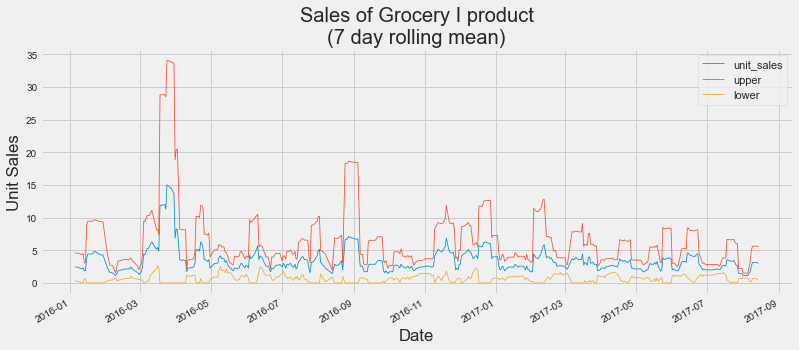

In [32]:
item_time_series_ma(105737,'Sales of Grocery I product\n(7 day rolling mean)', rolling_time_span=7, mean_std=1,
                     start_date='2016-01-01', finish_date='2017-08-15', save_as='Groceries_Sales')

In [33]:
choosen_product = 105737
items[items['item_nbr'] == choosen_product]

,item_nbr,family,class,perishable
8,105737,GROCERY I,1044,0


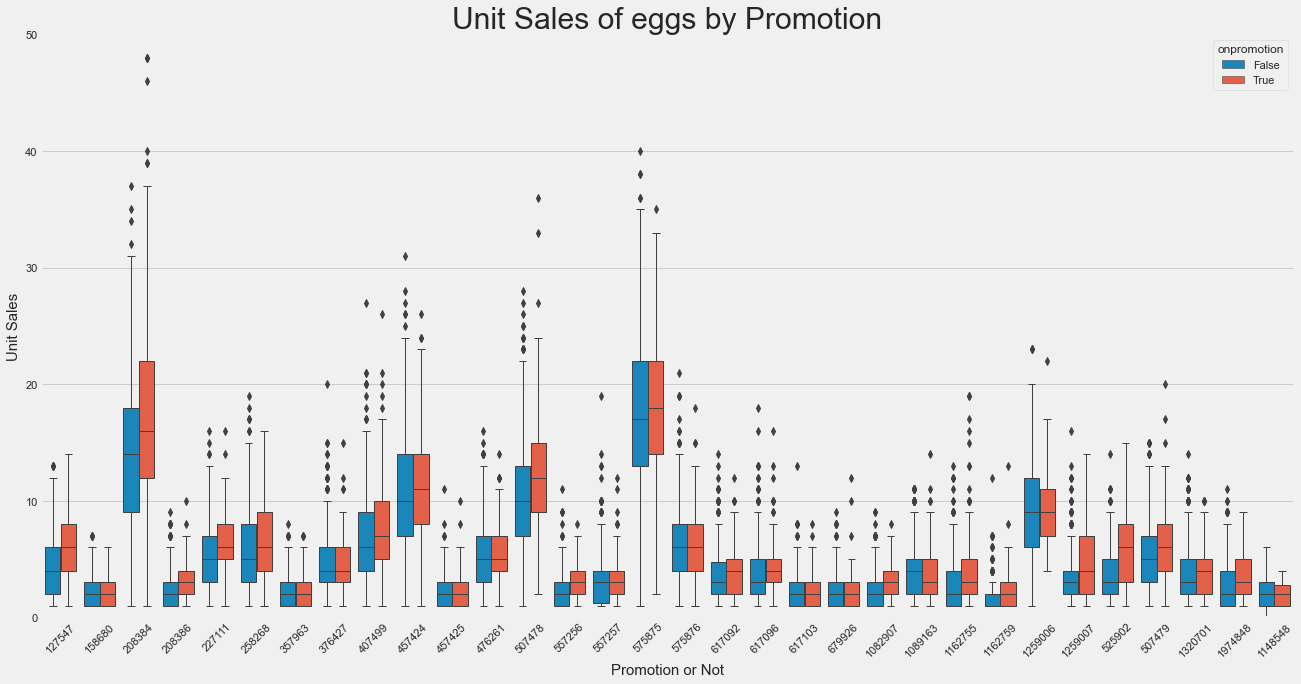

In [34]:
#data
product = 'EGGS'
family = items[items['family'] == product].item_nbr.tolist()
data = train[(train['item_nbr'].isin(family)) & (train['onpromotion'] != 'No Info')]

#size
plt.figure(figsize=(20,10))

# Generate a boxplot
ax = sns.boxplot(y='unit_sales', x='item_nbr', hue='onpromotion', data=data, linewidth=1) 

# Set the labels and display the plot
ax.set_title('Unit Sales of {} by Promotion'.format(product.casefold()), size=30)
ax.set_xlabel('Promotion or Not', fontsize=15)
ax.set_ylabel('Unit Sales', fontsize=15)
ax.set_xticklabels(labels=data['item_nbr'].unique().tolist(), rotation=45, ha='center')
ax.set_ylim(bottom=0, top=50)

# Show plot
plt.savefig('img/Eggs_Sales.png', bbox_inches='tight',transparent=True)
plt.show()

In [35]:
family_list = train.sort_values(by='unit_sales', ascending=False)['family'].unique().tolist()
family_list = [family_list[i:i + 8] for i in range(0, len(family_list), 8)]

In [36]:
data['unit_sales'].max()

74.0

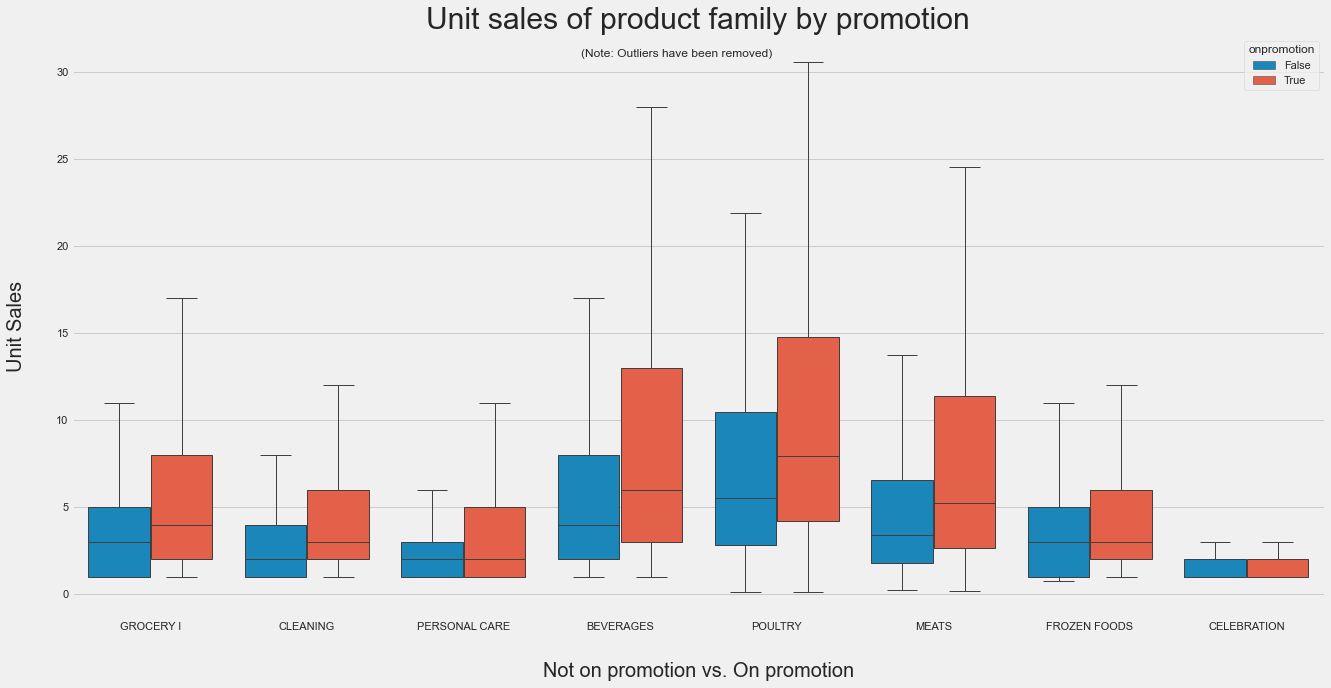

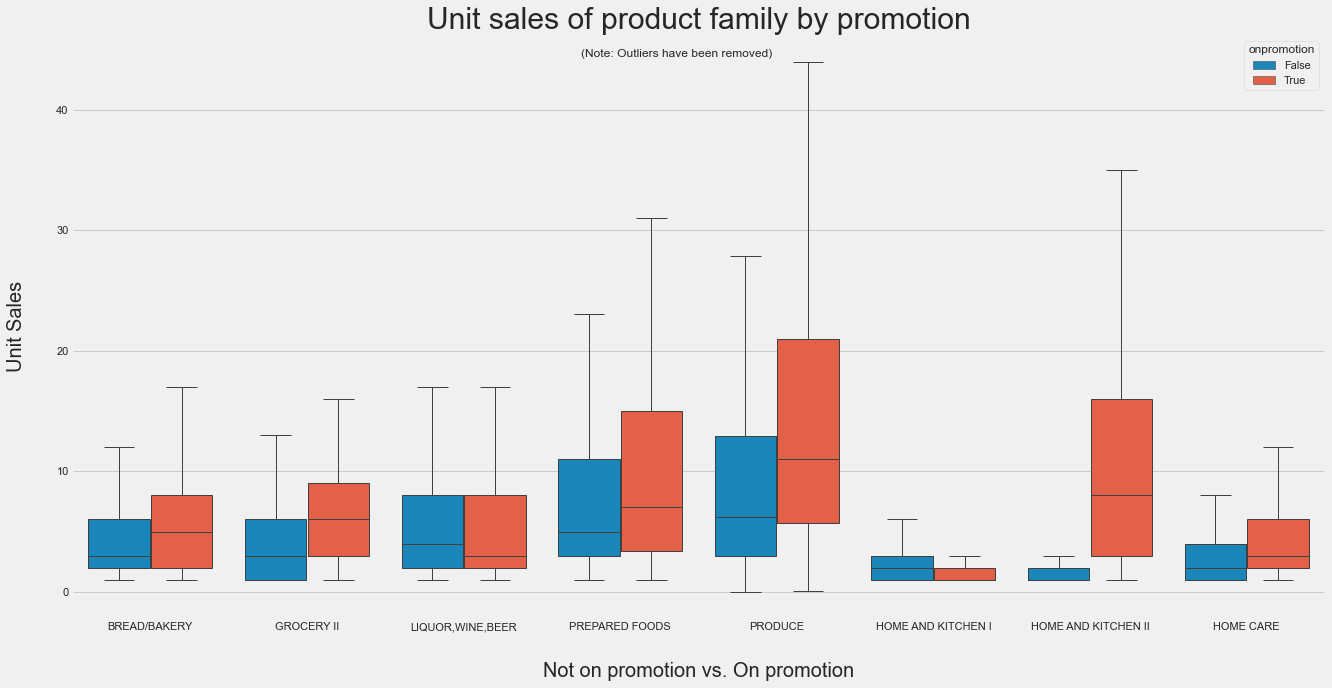

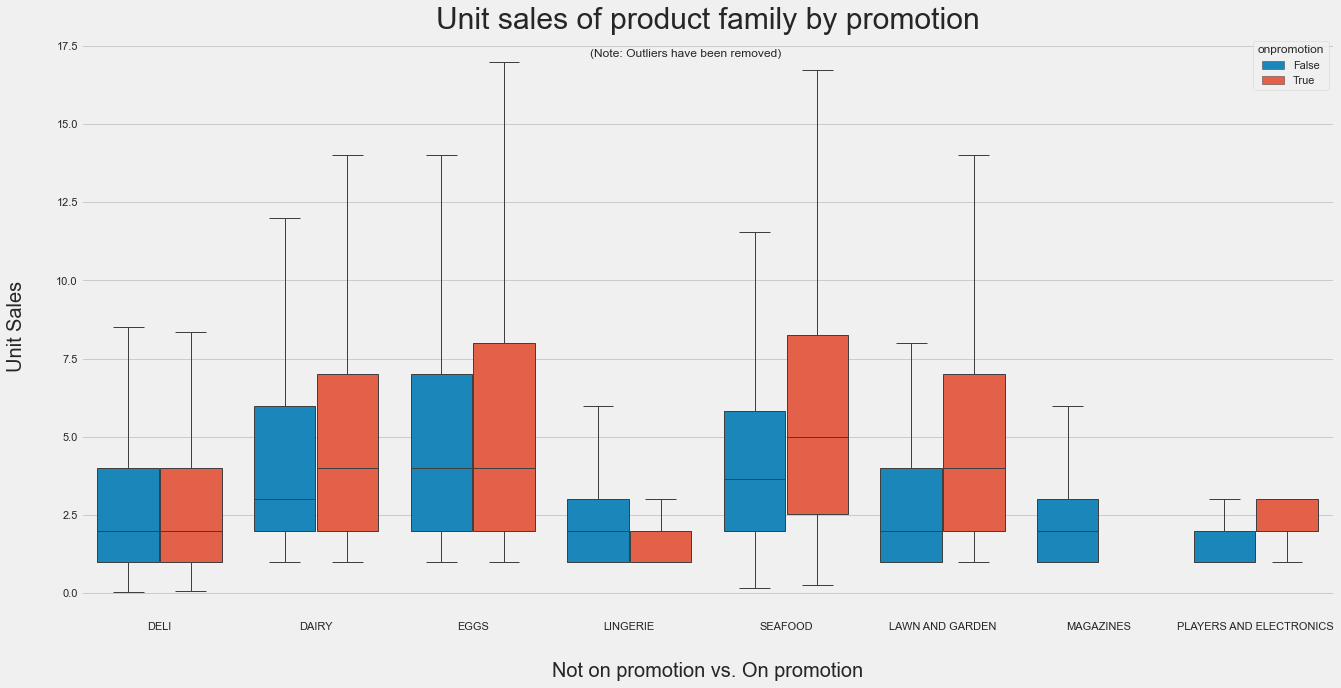

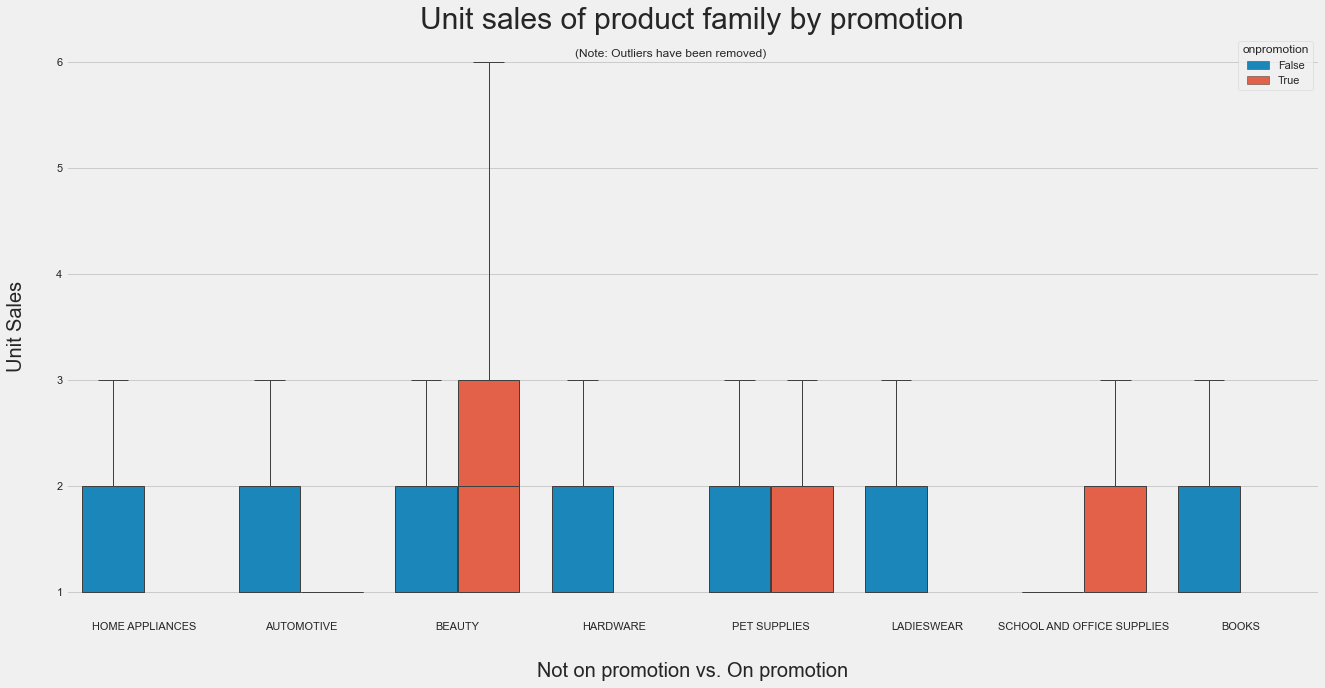

In [37]:
for number, group in enumerate(family_list):
    
    #data
    data = train[(train['onpromotion'] != 'No Info') & (train['family'].isin(group)) & (train['unit_sales'] > 0)]
    
    #size
    plt.figure(figsize=(20,10))

    # Generate a boxplot
    ax = sns.boxplot(y='unit_sales', x='family', hue='onpromotion', data=data, showfliers=False, linewidth=1) 

    # Set the labels and display the plot
    ax.set_title('Unit sales of product family by promotion'.format(product.casefold()), size=30)
    plt.figtext(.5,.85,'(Note: Outliers have been removed)',fontsize=12,ha='center')
    ax.set_xlabel('Not on promotion vs. On promotion', fontsize=20, labelpad=30)
    ax.set_ylabel('Unit Sales', fontsize=20,labelpad=30)
    
    plt.savefig('img/Promotion/product_family_promotion_group_'+str(number)+'.png', bbox_inches='tight',transparent=True)
    plt.show()

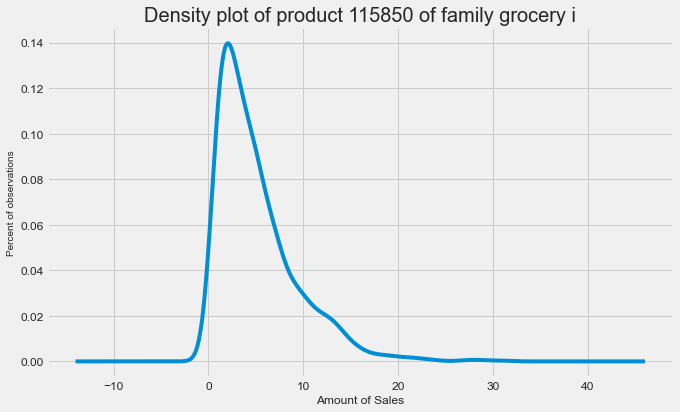

In [38]:
select_product = 115850

# Display density plot
ax = train[train['item_nbr']==select_product]['unit_sales'].plot(kind='density', linewidth=4, fontsize=12, figsize=(10,6))
product_id = train[train['item_nbr']==select_product]['item_nbr'].head(1).tolist()
family_name = train[train['item_nbr']==select_product]['family'].head(1).tolist()

# Annotate
ax.set_title('Density plot of product {} of family {}'.format(product_id[0], family_name[0].casefold()), size=20)
ax.set_xlabel('Amount of Sales', fontsize=12)
ax.set_ylabel('Percent of observations', fontsize=10)

plt.savefig('img/Products/'+family_name[0]+' '+str(product_id[0])+'.png', bbox_inches='tight',transparent=True)
plt.show()

<a id='clustermap'></a>


## Clustermap - Are sales of families of products correlated between them?
***

In [39]:
df_corr = train.drop(train.columns.difference(['date','unit_sales','family']), axis=1)
df_corr = df_corr.groupby(['date','family']).sum()
df_corr = df_corr.reset_index(level=1).pivot(columns='family', values='unit_sales').corr()

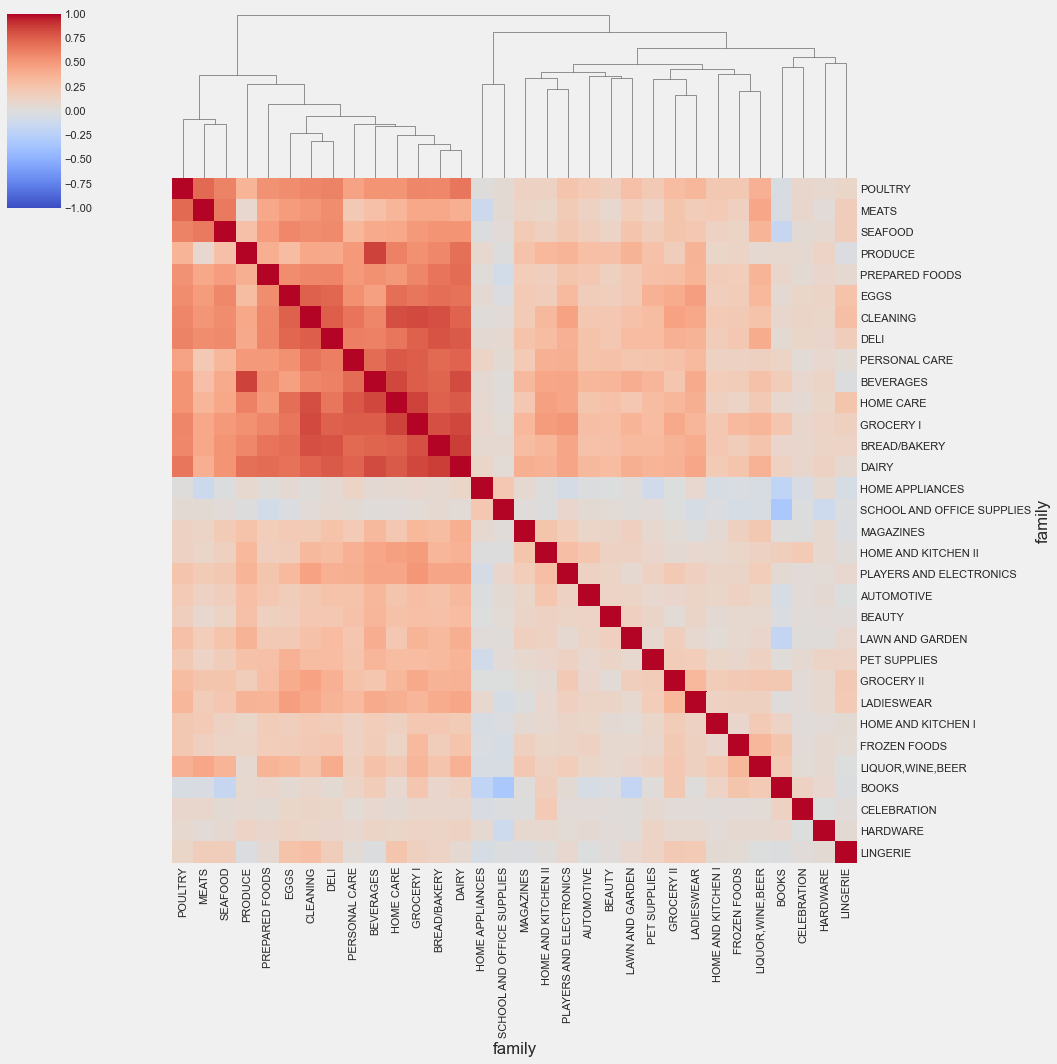

In [40]:
# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(df_corr,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(15, 15),
                    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

fig.ax_row_dendrogram.remove()

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.savefig('img/Insights/clustermap.png', bbox_inches='tight',transparent=True)
plt.show()

**Personal Note:** Add on the side information about perishable or not perishable

<a id='volcano'></a>


## Volcano Plot - What family of products are most influenced by promotions?
***

In [41]:
df_volcano = train.drop(train.columns.difference(['date','unit_sales','family','onpromotion']), axis=1)

In [42]:
df_volcano = df_volcano[df_volcano['onpromotion'] != 'No Info']

In [43]:
family = df_volcano['family'].unique().tolist()

no_promotion = []
for i in family:
    if len(df_volcano[df_volcano['family'] == i]['onpromotion'].unique()) == 2:
        pass
    else:
        no_promotion.append(i)
print('These families of products do not have data on promotions', no_promotion)

These families of products do not have data on promotions ['HOME APPLIANCES', 'HARDWARE', 'MAGAZINES', 'LADIESWEAR', 'BOOKS']


In [44]:
df_volcano = df_volcano[df_volcano['family'].isin([e for e in family if e not in no_promotion])]
df_volcano = df_volcano.reset_index().drop('date',axis=1)
df_volcano['onpromotion'] = df_volcano.onpromotion.replace('True', True)

In [45]:
volcano = {}

for i in [e for e in family if e not in no_promotion]:
    
    x = df_volcano[(df_volcano['family'] == i) & (df_volcano['onpromotion'] == False)]
    y = df_volcano[(df_volcano['family'] == i) & (df_volcano['onpromotion'] == True)]

    H, pval = stats.mannwhitneyu(x=x['unit_sales'], y=y['unit_sales'])
    mean_difference = y['unit_sales'].mean() - x['unit_sales'].mean()
    
    if pval < 0.05:
        significance = True
    if pval > 0.05:
        significance = False
        
    volcano[i] = [H, pval, mean_difference, significance]
    
volcano_dataframe = pd.DataFrame(volcano).T
volcano_dataframe.columns = ['H', 'p_value', 'mean_difference', 'significant']
volcano_dataframe = volcano_dataframe.infer_objects()

volcano_dataframe

,H,p_value,mean_difference,significant
GROCERY I,7.333128e+09,0.000000e+00,2.716159,True
BREAD/BAKERY,9.573078e+07,1.009428e-48,0.948913,True
DELI,1.861888e+08,8.686382e-70,0.463628,True
CLEANING,8.353816e+08,5.060933e-213,1.261257,True
PERSONAL CARE,7.557262e+07,6.888713e-91,1.705247,True
BEVERAGES,1.727323e+09,0.000000e+00,4.620924,True
DAIRY,6.594721e+08,9.673562e-64,0.645741,True
EGGS,5.813664e+07,6.403534e-32,1.011530,True
POULTRY,8.227454e+07,5.339221e-151,4.552058,True
GROCERY II,8.973300e+04,2.592889e-05,2.149977,True


In [46]:
new_alpha = 0.05/len(volcano_dataframe)
new_alpha

0.001851851851851852

In [47]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(volcano_dataframe['p_value'], method='bonferroni', alpha=new_alpha)

In [48]:
volcano_dataframe['p_value_corrected'] = p_adjusted[1]
volcano_dataframe['signficance_corrected'] = p_adjusted[0]

In [49]:
#we need to add a small number for the 0s or the log will not work
volcano_dataframe['p_value_corrected'] = volcano_dataframe['p_value_corrected'].replace(to_replace=0, value=10**-100)

In [50]:
mean_sales = df_volcano[df_volcano['onpromotion'] == False].groupby('family').mean()[['unit_sales']]
mean_sales.columns = ['mean_sales_no_promotion']

In [51]:
volcano_dataframe = volcano_dataframe.merge(mean_sales, left_on=volcano_dataframe.index, right_on=mean_sales.index).set_index('key_0')

In [52]:
volcano_dataframe['mean_difference_percentage_sales'] = (volcano_dataframe['mean_difference']/volcano_dataframe['mean_sales_no_promotion'])*100

In [53]:
volcano_dataframe

,H,p_value,mean_difference,significant,p_value_corrected,signficance_corrected,mean_sales_no_promotion,mean_difference_percentage_sales
key_0,,,,,,,,
GROCERY I,7.333128e+09,0.000000e+00,2.716159,True,1.000000e-100,True,4.076585,66.628298
BREAD/BAKERY,9.573078e+07,1.009428e-48,0.948913,True,2.725456e-47,True,5.570006,17.036115
DELI,1.861888e+08,8.686382e-70,0.463628,True,2.345323e-68,True,2.902897,15.971210
CLEANING,8.353816e+08,5.060933e-213,1.261257,True,1.366452e-211,True,3.489142,36.148061
PERSONAL CARE,7.557262e+07,6.888713e-91,1.705247,True,1.859953e-89,True,2.619558,65.096751
BEVERAGES,1.727323e+09,0.000000e+00,4.620924,True,1.000000e-100,True,7.046854,65.574292
DAIRY,6.594721e+08,9.673562e-64,0.645741,True,2.611862e-62,True,4.899905,13.178641
EGGS,5.813664e+07,6.403534e-32,1.011530,True,1.728954e-30,True,5.254527,19.250631
POULTRY,8.227454e+07,5.339221e-151,4.552058,True,1.441590e-149,True,8.537704,53.317124


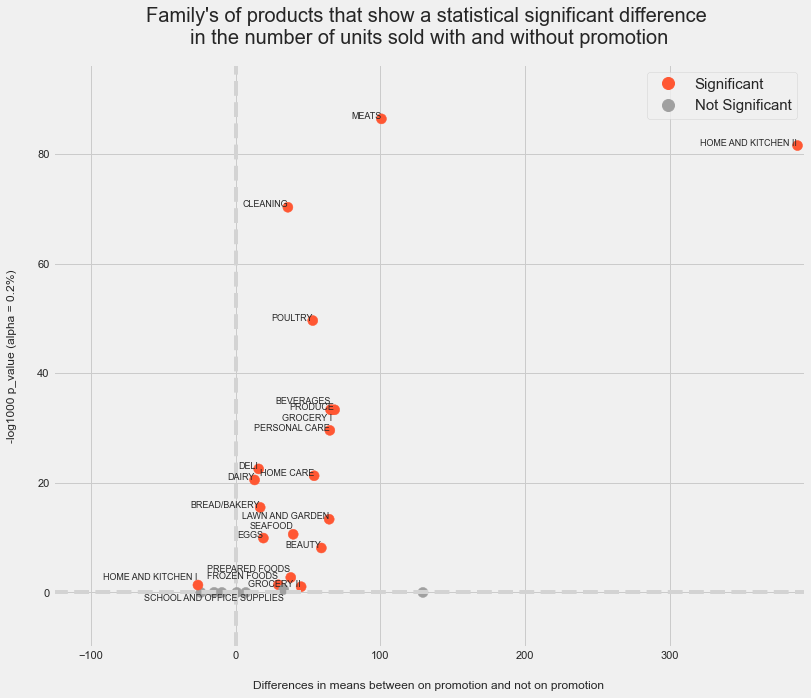

In [54]:
colors = ['#a0a0a0', '#FF5733']

x = list(volcano_dataframe['mean_difference_percentage_sales'])

data = volcano_dataframe['p_value_corrected']
base = 1000
y = (np.log(data) / np.log(base))*-1


plt.figure(figsize=(12,10))
plt.scatter(x, y, c=volcano_dataframe['signficance_corrected'], cmap=mpl.colors.ListedColormap(colors),s=100)
plt.xlabel('Differences in means between on promotion and not on promotion',fontsize = 12, labelpad=20)
plt.ylabel('-log'+str(base)+' p_value (alpha = {}%)'.format(round(new_alpha*100,1)),fontsize = 12, labelpad=20)

plt.ylim(-10,max(y)+10)
plt.xlim(min(volcano_dataframe['mean_difference_percentage_sales'])-100,max(volcano_dataframe['mean_difference_percentage_sales'])+5)
plt.title('Families of products that show a significant statistical difference \nin the number of units sold with and without promotion',fontsize=20, pad=20)
plt.axvline(x=0, linestyle='dashed', color='lightgray')
plt.axhline(y=0, linestyle='dashed', color='lightgray')

plt.legend([mpl.lines.Line2D([0], [0], marker='o', ms= 12, ls='', c='#FF5733'),
           mpl.lines.Line2D([0], [0], marker='o', ms= 12, ls='', c='#a0a0a0')],
          ['Significant', 'Not Significant'], fontsize=15,fancybox=True)

for i, txt in enumerate(list(volcano_dataframe.index)):
    if txt in data[data > 0.05].index:
        pass
    elif txt in ['BEVERAGES','SEAFOOD','PREPARED FOODS','FROZEN FOODS','HOME AND KITCHEN I']:
        plt.annotate(txt, (x[i]-0.1, y[i]+1), fontsize=9, ha='right')
    elif txt in ['GROCERY I', 'SCHOOL AND OFFICE SUPPLIES']:
        plt.annotate(txt, (x[i]-0.1, y[i]-2), fontsize=9, ha='right')
    else:
        plt.annotate(txt, (x[i]-0.1, y[i]), fontsize=9, ha='right')

plt.savefig('img/Insights/Volcano Plot.png', transparent=True, dpi=200)
plt.show()

<a id='top3'></a>


## Top 3: What family of products are sold most each month?
***

In [55]:
top3_df = train[['unit_sales','family']]

In [57]:
top3_months = top3_df.index.month

In [58]:
top3_df = top3_df.groupby(['family', top3_months]).sum()
top3_df = top3_df.unstack(level=1)
top3_df.columns = top3_df.columns.droplevel()
top3_df = top3_df.apply(lambda x: x/top3_df.sum(axis=1))
top3_df.columns = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [59]:
top3_dictionary = {}
for i in top3_df:
    result = top3_df[i].nlargest(3)
    top3_dictionary[i] = ([list(pair) for pair in zip(result.index, result.values)])


In [60]:
top3 = pd.DataFrame(top3_dictionary)

In [61]:
top3['Jan'][0][1]

0.12380952380952381

In [62]:
top3_plot = {}
top3_text = {}
for i in top3:
    values = []
    family = []
    for e in top3[i]:
        values.append(e[1])
        family.append(e[0])
    top3_plot[i] = values    
    top3_text[i] = family

In [63]:
values = pd.DataFrame(top3_plot)

In [64]:
text = pd.DataFrame(top3_text)

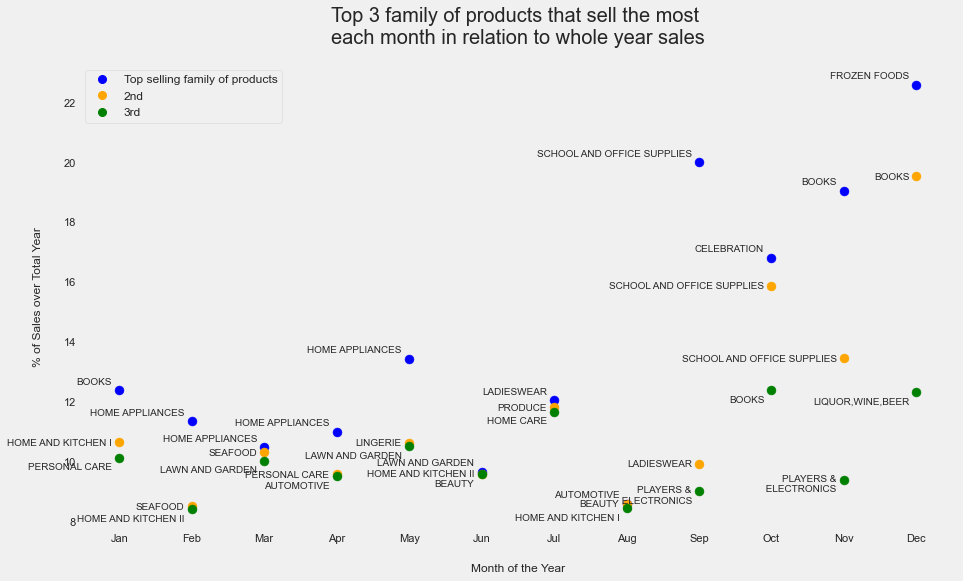

In [65]:
plt.figure(figsize=(14,8))
ax1 = plt.scatter(x=range(1,13),y=values.iloc[0]*100, s=80, c='blue')
ax2 = plt.scatter(x=range(1,13),y=values.iloc[1]*100, s=80, c='orange')
ax3 = plt.scatter(x=range(1,13),y=values.iloc[2]*100, s=80, c='green')

plt.title('Top 3 family of products that sell the most \neach month in relation to whole year sales',fontsize=20, pad=20)
plt.xlabel('Month of the Year',fontsize = 12, labelpad=20)
plt.ylabel('% of Sales over Total Year',fontsize = 12, labelpad=20)
plt.xticks(ticks=range(1,13), labels=values.columns.tolist())
plt.grid(False)

plt.legend([mpl.lines.Line2D([0], [0], marker='o', ms= 8, ls='', c='blue'),
           mpl.lines.Line2D([0], [0], marker='o', ms= 8, ls='', c='orange'),
           mpl.lines.Line2D([0], [0], marker='o', ms= 8, ls='', c='green')],
          ['Top selling family of products', '2nd', '3rd'], fontsize=12,fancybox=True)

for month, percentage, txt in zip(range(1,13), values.iloc[0]*100, text.iloc[0]):
    plt.annotate(txt, (month-0.1, percentage+0.2), fontsize=10, ha='right')
for month, percentage, txt in zip(range(1,13), values.iloc[1]*100, text.iloc[1]):
    plt.annotate(txt, (month-0.1, percentage-0.1), fontsize=10, ha='right')
for month, percentage, txt in zip(range(1,13), values.iloc[2]*100, text.iloc[2]):
    if txt == 'PLAYERS AND ELECTRONICS':
        plt.annotate('PLAYERS &\n ELECTRONICS', (month-0.1, percentage-0.4), fontsize=10, ha='right')
    else:
        plt.annotate(txt, (month-0.1, percentage-0.4), fontsize=10, ha='right')

plt.savefig('img/Insights/Top_3.png', transparent=True, dpi=200)
plt.show()